# Demo: guided proposal for Brownian bridge 

In [80]:
import DiffusionBridge as db
import torch
import matplotlib.pyplot as plt
from DiffusionBridge.utils import normal_logpdf
plt.style.use('ggplot')

In [76]:
# problem settings
d = 2
f = lambda t,x: torch.zeros_like(x)
sigma = torch.tensor(1.0)
T = torch.tensor(10.0)
M = 100
diffusion = db.diffusion.model(f, sigma, d, T, M)

# initial and terminal constraints
X0 = 0.0 * torch.ones(d)
XT = 5.0 * torch.ones(d)

# transition density
transition_mean = lambda t,x: x
transition_var = lambda t: t * sigma * sigma
score_transition = lambda t,x: (transition_mean(t, X0) - x) / transition_var(t)
log_transition_density = normal_logpdf(XT.reshape(1, d), transition_mean(T, X0), transition_var(T))
print('log-transition density: ' + str(float(log_transition_density)))

# marginal density
grad_logh = lambda t,x: (XT - transition_mean(T - t, x)) / transition_var(T - t)


log-transition density: -6.6404619216918945


In [79]:
len(transition_var(T).shape)


0

In [71]:
class AuxiliaryDiffusion:
    def __init__(self, initial_beta):
        self.beta = torch.tensor(initial_beta, requires_grad=True)

    def f(self, t, x):
        return self.beta

    def log_transition(self, s, xs, t, xt):
        aux_transition_mean = xs + (t - s) * self.beta
        aux_transition_var = (t - s) * diffusion.Sigma
        log_density = normal_logpdf(xt, aux_transition_mean, aux_transition_var)
        return log_density

    def grad_logh(self, invSigma, terminal_state, terminal_time, t, x):
        output = (
            invSigma * (terminal_state - x) / (terminal_time - t) - invSigma * self.beta
        )
        return output


def log_radon_nikodym(trajectories, aux_diffusion):
    """
    Evaluate gradient function needed in score matching to learn score of transition density.

    Parameters
    ----------
    trajectories : realizations of time-discretized process (N, M+1, d)

    aux_diffusion : instance of class AuxiliaryDiffusion

    Returns
    -------
    log_rn : gradient function evaluations (N, M, d)
    """

    N = trajectories.shape[0]
    M = diffusion.num_steps
    invSigma = diffusion.invSigma
    terminal_time = diffusion.T
    initial_state = trajectories[:, 0, :]
    terminal_state = trajectories[:, -1, :]
    G = torch.zeros(N, M)

    for m in range(M):
        t_current = diffusion.time[m]
        X_current = trajectories[:, m, :]
        diff_f = diffusion.f(t_current, X_current) - aux_diffusion.f(t_current, X_current)  # size (N, d)
        grad_logh = aux_diffusion.grad_logh(
            invSigma, terminal_state, terminal_time, t_current, X_current
        )  # size (N, d)
        G[:, m] = torch.sum(diff_f * grad_logh, 1) * diffusion.stepsizes[m]  # size (N)

    log_rn = torch.sum(G, 1) + aux_diffusion.log_transition(
        0.0, initial_state, terminal_time, terminal_state
    )  # size (N)

    return log_rn

In [72]:
def learn_guided_proposal(
    initial_beta,
    initial_state,
    terminal_state,
    minibatch,
    num_iterations,
    learning_rate,
):
    N = minibatch
    M = diffusion.num_steps
    loss_values = torch.zeros(num_iterations)
    beta_values = torch.zeros(num_iterations, d)

    # create auxiliary diffusion
    aux_diffusion = AuxiliaryDiffusion(initial_beta)

    # optimization
    optimizer = torch.optim.SGD([aux_diffusion.beta], lr=learning_rate)
    for i in range(num_iterations):
        # simulate trajectories from auxiliary proposal process
        with torch.no_grad():
            proposal_drift = lambda t,x: diffusion.f(t,x) + diffusion.Sigma * aux_diffusion.grad_logh(
                diffusion.invSigma, terminal_state, diffusion.T, t, x
            )
            simulation_output = diffusion.simulate_proposal_bridge(
                proposal_drift,
                initial_state,
                terminal_state,
                N,
            )
            trajectories = simulation_output["trajectories"]
            log_weights = log_radon_nikodym(trajectories, aux_diffusion)
            max_log_weights = torch.max(log_weights)
            weights = torch.exp(log_weights - max_log_weights)
            normalized_weights = weights / torch.sum(weights)

        # estimate kullback leibler 
        log_rn = log_radon_nikodym(trajectories, aux_diffusion)
        loss = torch.sum(log_rn * normalized_weights)

        # backpropagation
        loss.backward()

        # optimization step and zero gradient
        optimizer.step()
        optimizer.zero_grad()

        # iteration counter
        current_loss = loss.item()
        loss_values[i] = current_loss
        if (i == 0) or ((i+1) % 50 == 0):
            print("Optimization iteration:", i+1, "Loss:", current_loss)
        beta_values[i,:] = aux_diffusion.beta

    # output 
    output = {
        'aux_diffusion': aux_diffusion,
        'loss' : loss_values,
        'beta': beta_values
    }

    return output


/var/folders/k3/bhywgh6117xbssfq3k_p40kw0000gn/T/ipykernel_18930/223349531.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.beta = torch.tensor(initial_beta, requires_grad=True)


Optimization iteration: 1 Loss: -814.6676025390625
Optimization iteration: 50 Loss: -6.6390910148620605
Optimization iteration: 100 Loss: -6.640392780303955
Optimization iteration: 150 Loss: -6.641152858734131
Optimization iteration: 200 Loss: -6.640589237213135
Optimization iteration: 250 Loss: -6.633711338043213
Optimization iteration: 300 Loss: -6.641338348388672
Optimization iteration: 350 Loss: -6.6386332511901855
Optimization iteration: 400 Loss: -6.639620780944824
Optimization iteration: 450 Loss: -6.639821529388428
Optimization iteration: 500 Loss: -6.637172222137451


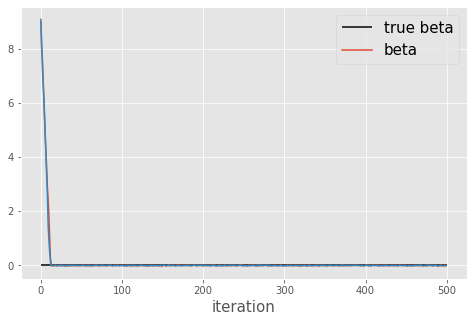

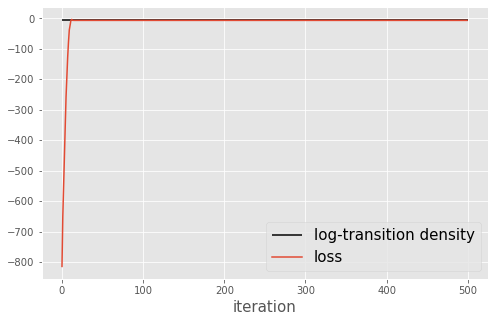

In [73]:
niter = 500
output = learn_guided_proposal(
    # initial_beta=2.0 * torch.randn(d),
    initial_beta=10.0 * torch.ones(d),
    initial_state=X0,
    terminal_state=XT,
    minibatch=1000,
    num_iterations=niter,
    learning_rate=0.1,
)

plt.figure(figsize=(8, 5))
plt.hlines(0.0, 0, niter, color="black")
plt.plot(output["beta"].detach().numpy())
plt.xlabel("iteration", fontsize=15)
plt.legend(["true beta", "beta"], fontsize=15)

plt.figure(figsize=(8,5))
plt.hlines(float(log_transition_density), 0, niter, color='black')
plt.plot(output['loss'].detach().numpy())
plt.xlabel('iteration', fontsize=15)
plt.legend(['log-transition density', 'loss'], fontsize=15)

In [74]:
N = 2**10
proposal_drift = lambda t,x: diffusion.f(t,x) + diffusion.Sigma * output['aux_diffusion'].grad_logh(
                diffusion.invSigma, XT, diffusion.T, t, x
            )
with torch.no_grad():
    simulation_output = diffusion.simulate_proposal_bridge(proposal_drift, X0, XT, N)
    trajectories = simulation_output['trajectories']
    log_proposal = simulation_output['logdensity']
log_target = diffusion.law_bridge(trajectories) 
log_weights = log_target - log_proposal

# importance sampling
max_log_weights = torch.max(log_weights)
weights = torch.exp(log_weights - max_log_weights)
norm_weights = weights / torch.sum(weights)
ess = 1.0 / torch.sum(norm_weights**2)
log_transition_estimate = torch.log(torch.mean(weights)) + max_log_weights
print("log-transition density:", float(log_transition_density))
print("IS log-transition estimate:", float(log_transition_estimate))
print("ESS%:", float(ess * 100 / N))

# independent Metropolis-Hastings
with torch.no_grad():
    initial = diffusion.simulate_proposal_bridge(proposal_drift, X0, XT, 1)
    current_trajectory = initial['trajectories']
    current_log_proposal = initial['logdensity'] 
current_log_target = diffusion.law_bridge(current_trajectory)
current_log_weight = current_log_target - current_log_proposal
num_accept = 0
for n in range(N):
    proposed_trajectory = trajectories[n, :, :]
    proposed_log_weight = log_weights[n]
    log_accept_prob = proposed_log_weight - current_log_weight

    if (torch.log(torch.rand(1)) < log_accept_prob):
        current_trajectory = proposed_trajectory.clone()
        current_log_weight = proposed_log_weight.clone()  
        num_accept += 1
accept_rate = num_accept / N
print("IMH acceptance rate:", accept_rate)

log-transition density: -6.6404619216918945
IS log-transition estimate: -6.667661666870117
ESS%: 50.613731384277344
IMH acceptance rate: 0.4775390625
